In [1]:
from PIL import Image
import numpy as np

def vstack(images):
    if len(images) == 0:
        raise ValueError("Need 0 or more images")

    if isinstance(images[0], np.ndarray):
        images = [Image.fromarray(img) for img in images]
    width = max([img.size[0] for img in images])
    height = sum([img.size[1] for img in images])
    stacked = Image.new(images[0].mode, (width, height))

    y_pos = 0
    for img in images:
        stacked.paste(img, (0, y_pos))
        y_pos += img.size[1]
    return stacked


def hstack(images):
    if len(images) == 0:
        raise ValueError("Need 0 or more images")

    if isinstance(images[0], np.ndarray):
        images = [Image.fromarray(img) for img in images]
    width = sum([img.size[0] for img in images])
    height = max([img.size[1] for img in images])
    stacked = Image.new(images[0].mode, (width, height))

    x_pos = 0
    for img in images:
        stacked.paste(img, (x_pos, 0))
        x_pos += img.size[0]
    return stacked

def grid_stack(image_paths, row_size):
    target_width = 2048
    rows = []
    for i in range(0, len(image_paths), row_size):
        imgs = [Image.open(p) for p in image_paths[i:i + row_size]]
        aspect_ratios = [img.size[0] / img.size[1] for img in imgs]
        target_height = int(round(target_width / sum(aspect_ratios)))
        
        resized_imgs = []
        current_width = 0
        for j, img in enumerate(imgs):
            if j == len(imgs) - 1:
                new_w = target_width - current_width
            else:
                new_w = int(round(target_height * aspect_ratios[j]))
                current_width += new_w
            resized_imgs.append(img.resize((new_w, target_height), Image.BILINEAR))
            
        rows.append(hstack(resized_imgs))

    return vstack(rows)

In [2]:
import dotenv   
dotenv.load_dotenv()

True

In [ ]:
import datasets
ds = datasets.load_dataset("weathon/ava_embeddings", split="train")

In [ ]:
ds = ds.with_format("numpy")

In [ ]:
import numpy as np

names = ds["name"]
sources = ds["source"]
arr = ds.data.column("embeddings").to_numpy()
arr = np.stack(arr, axis=0)
ava_dataset = ds.filter(lambda example: example["source"] == "ava")
ls_dataset = ds.filter(lambda example: example["source"] == "liminal_space")
lapis_dataset = ds.filter(lambda example: example["source"] == "lapis")
ava_embeddings = np.stack(ava_dataset["embeddings"], axis=0)
ls_embeddings = np.stack(ls_dataset["embeddings"], axis=0)
lapis_embeddings = np.stack(lapis_dataset["embeddings"], axis=0) 

In [ ]:
ava_names = ava_dataset["name"]
ls_names = ls_dataset["name"]
lapis_names = lapis_dataset["name"]

In [ ]:
import sys
sys.path.append("../")
from qwen3_vl_embedding import Qwen3VLEmbedder

model_name_or_path = "Qwen/Qwen3-VL-Embedding-8B"

model = Qwen3VLEmbedder(model_name_or_path=model_name_or_path, device="cuda:2", attn_implementation="sdpa")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/749 [00:00<?, ?it/s]

In [ ]:
import torch
torch.tensor(arr).cpu().float()
torch.zeros(len(torch.tensor(arr).cpu().float()), dtype=torch.bool)

tensor([False, False, False,  ..., False, False, False])

In [ ]:
import base64
from PIL import Image
from agents.tool import ToolOutputImage

def encode(image: Image) -> ToolOutputImage:
    from io import BytesIO
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    b64_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return ToolOutputImage(image_url=f"data:image/png;base64,{b64_str}", detail="high")

In [ ]:
ava_embeddings_tensor = torch.tensor(ava_embeddings).float()
ls_embeddings_tensor = torch.tensor(ls_embeddings).float()
lapis_embeddings_tensor = torch.tensor(lapis_embeddings).float()

ava_names_list = list(ava_names)
ls_names_list = list(ls_names)
lapis_names_list = list(lapis_names)

In [ ]:
from PIL import Image
import os

from agents import Agent, Runner, function_tool, set_default_openai_client, set_tracing_export_api_key
from openai import AsyncOpenAI
import torch
import time



dataset_map = {
    "photos": "ava",
    "dreamcore": "liminal_space",
    "artwork": "lapis"
}

def _search(query: str, dataset: str, negative_prompts: list[str] = [], negative_threshold: float = 0.3, t: int = 10, return_paths: bool = False) -> ToolOutputImage:
    t0 = time.time()
    print(f"[LOG] Searching for '{query}' in dataset '{dataset}' with negative prompt '{negative_prompts}' and threshold {negative_threshold} for {t} items...")

    t1 = time.time()
    query_texts = [
        {"text": text} for text in negative_prompts
    ]
    # print(f"[PROFILE] build query_texts: {time.time()-t1:.3f}s")

    t2 = time.time()
    embeddings = ava_embeddings_tensor if dataset == "photos" else ls_embeddings_tensor if dataset == "dreamcore" else lapis_embeddings_tensor
    names = ava_names_list if dataset == "photos" else ls_names_list if dataset == "dreamcore" else lapis_names_list
    # print(f"[PROFILE] load embeddings & names: {time.time()-t2:.3f}s, shapes: embeddings={embeddings.shape}, names={len(names)}")

    t3 = time.time()
    combined_mask = torch.zeros(len(embeddings), dtype=torch.bool)
    # print(f"[PROFILE] init combined_mask: {time.time()-t3:.3f}s")

    t4 = time.time()
    for i, q in enumerate(query_texts):
        t4i = time.time()
        q_emb = model.process([q]).cpu().float()
        t4p = time.time() - t4i
        
        t4s = time.time()
        sim = torch.nn.functional.cosine_similarity(embeddings, q_emb)
        t4sim = time.time() - t4s
        
        t4m = time.time()
        combined_mask |= (sim > negative_threshold)
        t4mask = time.time() - t4m
        
        # print(f"[PROFILE] negative prompt {i}/{len(query_texts)}: process={t4p:.3f}s, sim={t4sim:.3f}s, mask={t4mask:.3f}s")
    # print(f"[PROFILE] total negative loop: {time.time()-t4:.3f}s")

    t5 = time.time()
    target_indices = torch.where(combined_mask)[0].tolist()
    empty_images = {names[i].item() for i in target_indices}
    # print(f"[PROFILE] build empty_images: {time.time()-t5:.3f}s, count={len(empty_images)}")

    t6 = time.time()
    queries = [{"text": query}] 
    # print(f"[PROFILE] prep query: {time.time()-t6:.3f}s")

    t7 = time.time()
    query_embedding = model.process(queries).cpu()
    # print(f"[PROFILE] model.process query: {time.time()-t7:.3f}s, shape={query_embedding.shape}")

    t8 = time.time()
    res = torch.nn.functional.cosine_similarity(embeddings, query_embedding.float())
    # print(f"[PROFILE] cosine_similarity: {time.time()-t8:.3f}s")

    t9 = time.time()
    selected_images = []
    for idx in torch.argsort(res, descending=True):
        if names[idx].item() not in empty_images:
            selected_images.append(names[idx].item())
        if len(selected_images) >= t:
            break
    # print(f"[PROFILE] top-k loop: {time.time()-t9:.3f}s, iterations={len(res)}")

    print(f"[LOG] Search results: {selected_images}.")

    t10 = time.time()
    paths = [f"/home/wg25r/Downloads/ds/train/{dataset_map[dataset]}/{name}" for name in selected_images if os.path.exists(f"/home/wg25r/Downloads/ds/train/{dataset_map[dataset]}/{name}")]
    # print(f"[PROFILE] filter existing paths: {time.time()-t10:.3f}s, found={len(paths)}")
    if len(paths) == 0:
        return "No Image Found"
    t11 = time.time()
    whole_image = grid_stack(paths, row_size=5)
    # print(f"[PROFILE] grid_stack: {time.time()-t11:.3f}s")
    if return_paths:
        return paths
    t12 = time.time()
    result = encode(whole_image)
    # print(f"[PROFILE] encode: {time.time()-t12:.3f}s")

    # print(f"[PROFILE] TOTAL: {time.time()-t0:.3f}s")
    return result

@function_tool(failure_error_function=None)
def search(query: str, dataset: str, negative_prompts: list[str] = [], negative_threshold: float = 0.3, t: int = 10) -> ToolOutputImage:
    try:
        return _search(query, dataset, negative_prompts, negative_threshold, t)
    except Exception as e:
        print(f"[ERROR] Search failed: {e}")
        raise e

In [ ]:
# (query, dataset, min_threshold, max_threshold, count=5, negative_prompt=None, negative_threshold=0.2)
import random
@function_tool(failure_error_function=None)
def sample(query: str, dataset: str, min_threshold: float, max_threshold: float, count: int = 5, negative_prompts: list[str] = [], negative_threshold: float = 0.2):
    print(f"[LOG] Sampling for '{query}' in dataset '{dataset}' with negative prompt '{negative_prompts}' and threshold {negative_threshold} for {count} items...")

    query_texts = [
        {"text": text} for text in negative_prompts
    ]

    embeddings = ava_embeddings_tensor if dataset == "photos" else ls_embeddings_tensor if dataset == "dreamcore" else lapis_embeddings_tensor
    names = ava_names_list if dataset == "photos" else ls_names_list if dataset == "dreamcore" else lapis_names_list

    combined_mask = torch.zeros(len(embeddings), dtype=torch.bool)

    for i, q in enumerate(query_texts):
        q_emb = model.process([q]).cpu().float()
        
        sim = torch.nn.functional.cosine_similarity(embeddings, q_emb)
        
        combined_mask |= (sim > negative_threshold)
        
        # print(f"[PROFILE] negative prompt {i}/{len(query_texts)}: process={t4p:.3f}s, sim={t4sim:.3f}s, mask={t4mask:.3f}s")

    target_indices = torch.where(combined_mask)[0].tolist()
    empty_images = {names[i].item() for i in target_indices}

    queries = [{"text": query}] 

    query_embedding = model.process(queries).cpu()

    res = torch.nn.functional.cosine_similarity(embeddings, query_embedding.float())

    selected_images = []
    # find the range of results that are within the min and max threshold then sample
    mask = torch.logical_and(res >= min_threshold, res <= max_threshold)
    candidate_indices = torch.where(mask)[0].tolist()
    selected_indices = random.sample(candidate_indices, min(count, len(candidate_indices)))
    selected_images = [names[i].item() for i in selected_indices]

    print(f"[LOG] Sample results: {selected_images}.")

    paths = [f"/home/wg25r/Downloads/ds/train/{dataset_map[dataset]}/{name}" for name in selected_images if os.path.exists(f"/home/wg25r/Downloads/ds/train/{dataset_map[dataset]}/{name}")]
    
    if len(paths) == 0:
        return "No Image Found"
    whole_image = grid_stack(paths, row_size=5)

    result = encode(whole_image)

    return result


In [ ]:
    

# commit(query, dataset, threshold, negative_prompt=None, negative_threshold=0.2, message=None)
import json

commit_logbook = []
@function_tool(failure_error_function=None)
def commit(query: str, dataset: str, threshold: float, negative_prompts: list[str] = [], negative_threshold: float = 0.2, message: str = None):
    print(f"[LOG] Committing with message: {message}")
    # images = _search(query, dataset, negative_prompts, threshold=threshold, return_paths=True)
    print(f"[LOG] Sampling for '{query}' in dataset '{dataset}' with negative prompt '{negative_prompts}' and threshold {negative_threshold} for {count} items...")

    query_texts = [
        {"text": text} for text in negative_prompts
    ]

    embeddings = ava_embeddings_tensor if dataset == "photos" else ls_embeddings_tensor if dataset == "dreamcore" else lapis_embeddings_tensor
    names = ava_names_list if dataset == "photos" else ls_names_list if dataset == "dreamcore" else lapis_names_list

    combined_mask = torch.zeros(len(embeddings), dtype=torch.bool)

    for i, q in enumerate(query_texts):
        q_emb = model.process([q]).cpu().float()
        
        sim = torch.nn.functional.cosine_similarity(embeddings, q_emb)
        
        combined_mask |= (sim > negative_threshold)
        
        # print(f"[PROFILE] negative prompt {i}/{len(query_texts)}: process={t4p:.3f}s, sim={t4sim:.3f}s, mask={t4mask:.3f}s")

    target_indices = torch.where(combined_mask)[0].tolist()
    empty_images = {names[i].item() for i in target_indices}

    queries = [{"text": query}] 

    query_embedding = model.process(queries).cpu()

    res = torch.nn.functional.cosine_similarity(embeddings, query_embedding.float())

    selected_images = []
    mask = res >= threshold
    candidate_indices = torch.where(mask)[0].tolist()
    selected_images = [names[i].item() for i in candidate_indices]

    print(f"[LOG] Sample results: {selected_images}.")

    images = [f"/home/wg25r/Downloads/ds/train/{dataset_map[dataset]}/{name}" for name in selected_images if os.path.exists(f"/home/wg25r/Downloads/ds/train/{dataset_map[dataset]}/{name}")]
    
    commit_logbook.append({
        "query": query,
        "dataset": dataset,
        "threshold": threshold,
        "negative_prompt": negative_prompts,
        "negative_threshold": negative_threshold,
        "message": message,
        "size": len(images)
    })
    with open("dataset.jsonl", "a") as f:
        for image in images:
            f.write(json.dumps({
                "message": message,
                "image": image
            }) + "\n")
    
    return f"Committed with message: {message} with {len(images)} images."

@function_tool(failure_error_function=None)
def undo_last_commit():
    if len(commit_logbook) == 0:
        return "No commits to undo."
    last_commit = commit_logbook.pop()
    print(f"[LOG] Undid last commit: {last_commit}")
    return f"Undid last commit: {last_commit['message']}"


@function_tool(failure_error_function=None)
def status():
    return f"Total commits: {len(commit_logbook)}. Latest commit: {commit_logbook[-1] if len(commit_logbook) > 0 else 'None'}\n" + str(commit_logbook)

In [ ]:
out = _search("黑色纹理 表面 裂纹 焦黑 荒废感", "photos", negative_prompts=[
    "watermark",
    "empty image"
  ], negative_threshold=0.3, t=12) 

[LOG] Searching for '黑色纹理 表面 裂纹 焦黑 荒废感' in dataset 'photos' with negative prompt '['watermark', 'empty image']' and threshold 0.3 for 12 items...
[LOG] Search results: ['324882.jpg', '73307.jpg', '840801.jpg', '670060.jpg', '163660.jpg', '309746.jpg', '73853.jpg', '106531.jpg', '434453.jpg', '426844.jpg', '792364.jpg', '204106.jpg'].


(2048, 1443)


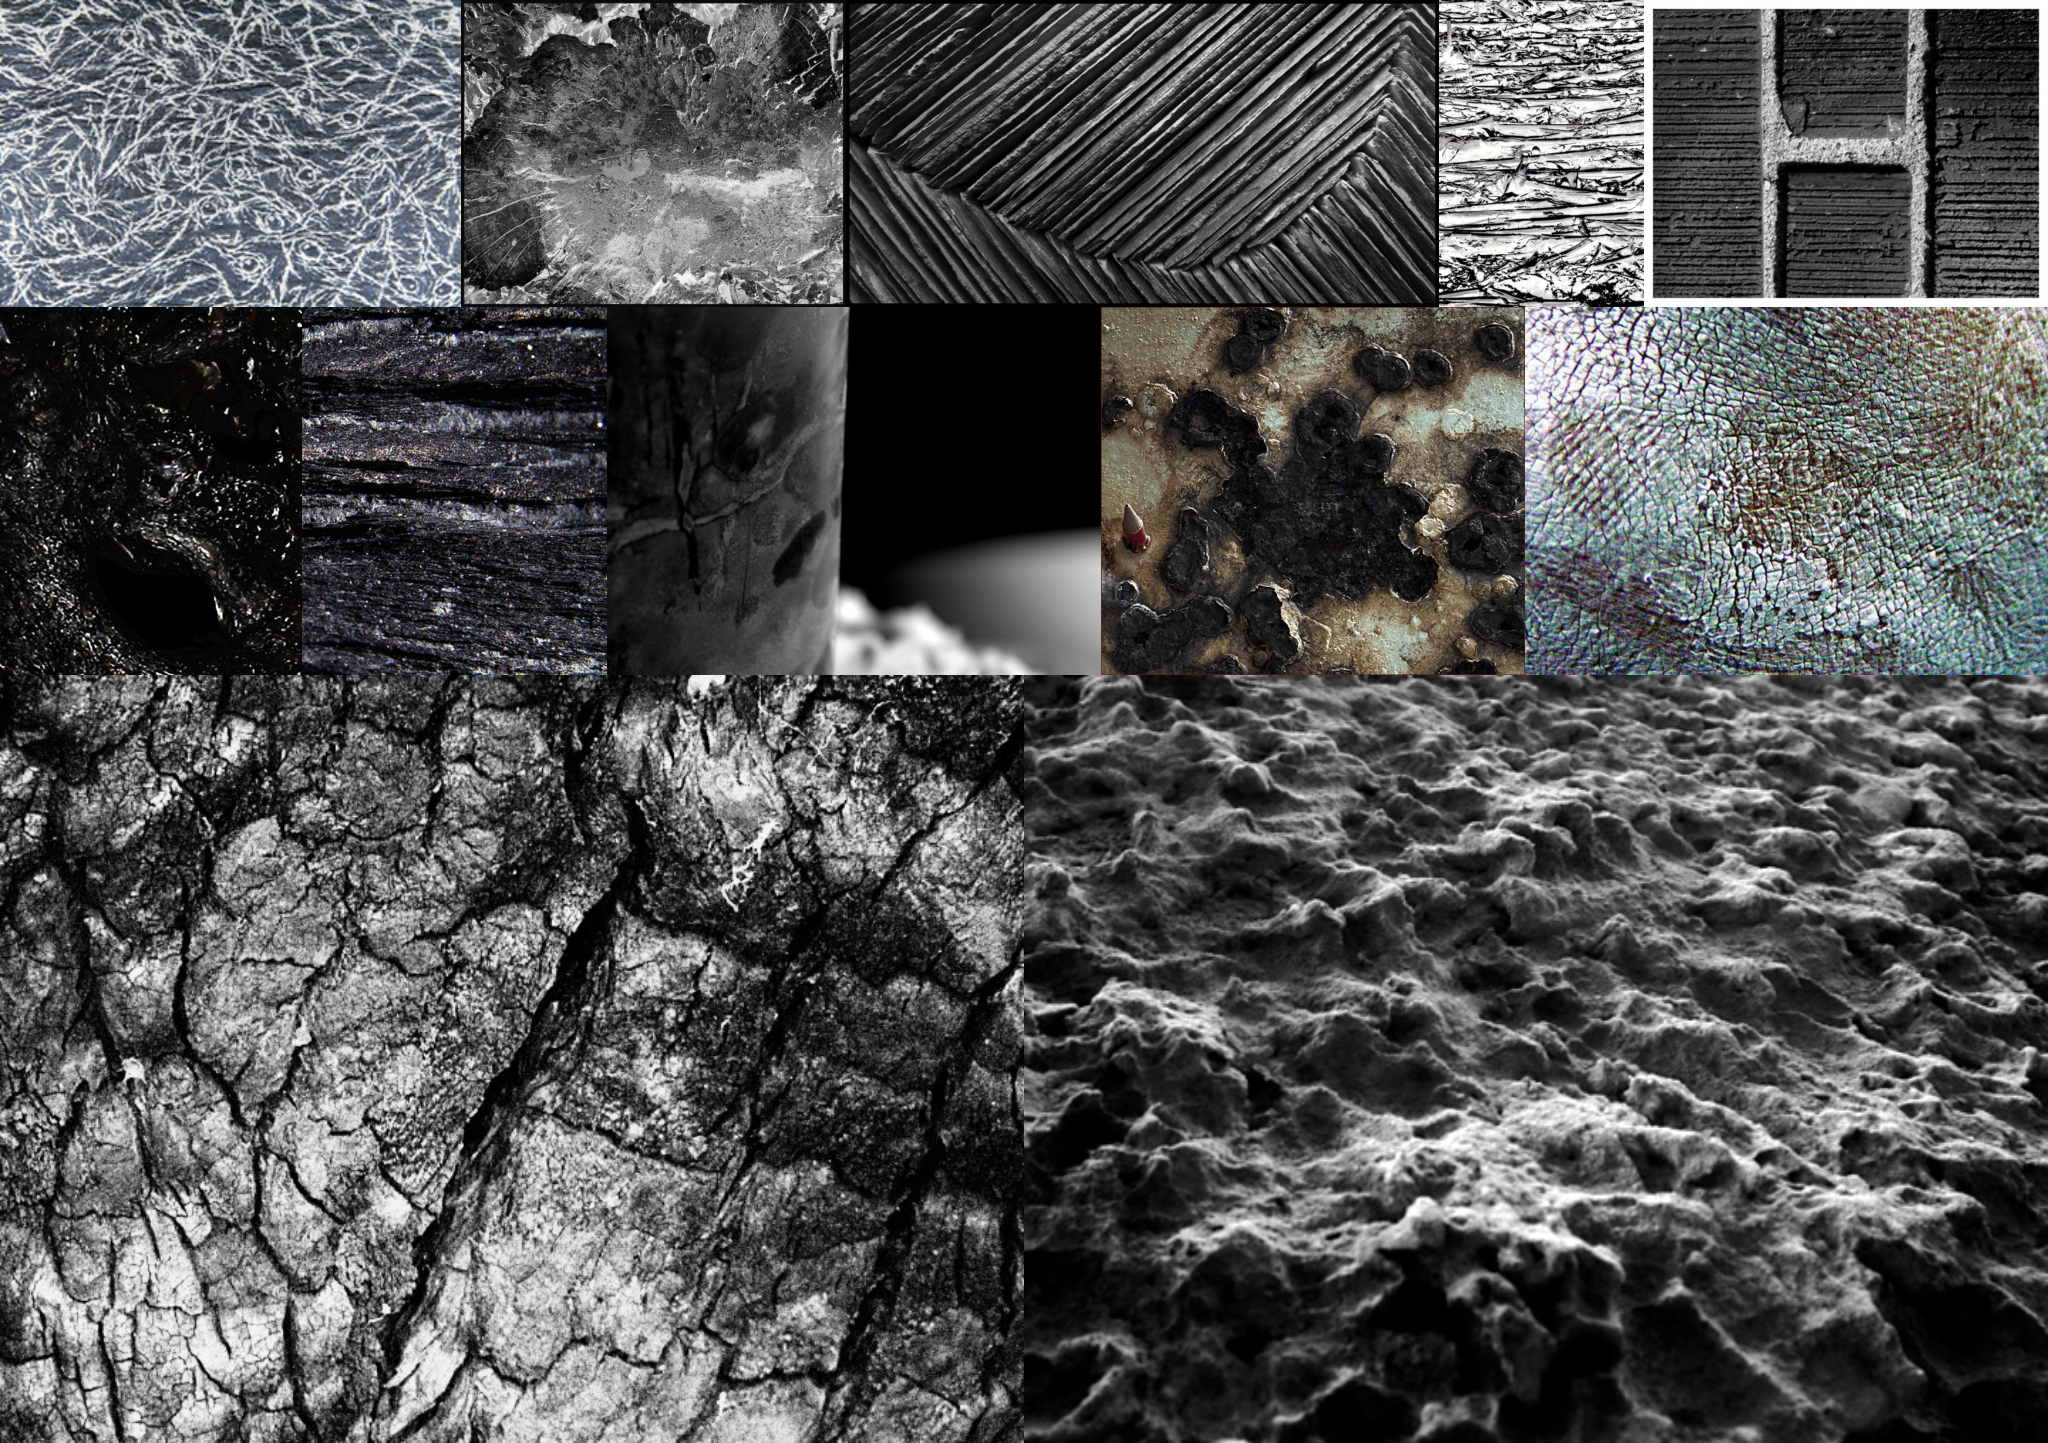

In [ ]:
# convert base64 to image and display
import base64
from PIL import Image
from io import BytesIO
b64_str = out.image_url.split(",")[1]
img_data = b64_str.encode("utf-8")
img = Image.open(BytesIO(base64.b64decode(img_data)))
print(img.size)
img

In [ ]:
with open("system_prompt.md", "r") as f:
    system_prompt = f.read()        

In [ ]:
import nest_asyncio
from agents import ModelSettings
nest_asyncio.apply()
dotenv.load_dotenv()
# custom_client = AsyncOpenAI(base_url="https://openrouter.ai/api/v1", api_key=os.getenv("OPENROUTER_API_KEY"))
custom_client = AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))
set_default_openai_client(custom_client)

# set_tracing_export_api_key(os.getenv("OPENAI_API_KEY"))

agent = Agent(name="Assistant", 
              tools=[search, commit, sample, undo_last_commit, status],
              instructions=system_prompt,
              model_settings=ModelSettings(
                  parallel_tool_calls=False
              ),
              model="gpt-5-nano")

result = await Runner.run(agent, "element: darkness.", max_turns=10)

[LOG] Searching for 'deep shadows high-contrast lighting chiaroscuro photography' in dataset 'photos' with negative prompt '['watermark', 'text_overlay', 'noise', 'overexposed', 'empty_frame']' and threshold 0.3 for 10 items...
[LOG] Search results: ['674367.jpg', '144855.jpg', '600207.jpg', '210131.jpg', '831298.jpg', '58380.jpg', '921576.jpg', '121481.jpg', '914087.jpg', '928349.jpg'].
[LOG] Committing with message: Sub-element: deep shadows, high-contrast lighting (traditional aesthetic, chiaroscuro)
[LOG] Searching for 'deep shadows high-contrast lighting chiaroscuro photography' in dataset 'photos' with negative prompt '['watermark', 'text_overlay', 'noise', 'overexposed', 'empty_frame']' and threshold 0.3 for 10 items...
[LOG] Search results: ['674367.jpg', '144855.jpg', '600207.jpg', '210131.jpg', '831298.jpg', '58380.jpg', '921576.jpg', '121481.jpg', '914087.jpg', '928349.jpg'].


CancelledError: 